In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import models
from keras import layers
from ActivationHeatmap.net import cnn_net
import matplotlib.pyplot as plt
import util.image_import as ii
import json, os
from keras import backend as K
import cv2
import glob

Using TensorFlow backend.


In [2]:
model = cnn_net()
model.load_weights('ActivationHeatmap/cnn_weights.hdf5')

In [3]:
def combine_labels_images():
    with open('ActivationHeatmap/label_data_copy.json') as json_file:
        data = json.load(json_file)

    orig_str = '/home/emil/Documents/github/BSc-PRO/dataset3/res_still'
    combined = []
    maps = os.listdir(orig_str)
    for m in maps:
        map_str =orig_str+'/'+m
        classes = os.listdir(map_str)
        for k in range(len(classes)):
            path_str = map_str+'/'+classes[k]
            names = os.listdir(path_str)
            count = 0
            for i in range(len(names)):
                for j in range(len(data)):
                    if names[i] == data[j]['External ID'] and (classes[k] != 'background'):
                        combined.append((m ,path_str+'/'+names[i], data[j] ))
    return combined

In [4]:
labels = ['bun','carrots','ketchup','background','catfood_beef','arm','catfood_salmon','potato']
train_path = '../dataset3/res_still/train'
ignore = []
mean_image_train = ii.calulate_mean(train_path, ignore) # Calculates mean for each channel for every pixel
def subtract_mean(img):
    return img - mean_image_train

In [5]:
combined = combine_labels_images()

In [6]:
y_pred = []
y = []
for indx in range(len(combined)):
    if combined[indx][0] == 'test':
        current = combined[indx]
        map_str = '/home/emil/Documents/github/BSc-PRO/dataset3/res_still/test'
        classes = os.listdir(map_str)
        for c in classes:
            label = current[2]['Label']
            if c in label:
                cor_c = c
        y.append(labels.index(cor_c))
        img_path = combined[indx][1]
        # load image and resize to 224x224
        img = image.load_img(img_path, target_size=(224,224))
        x = image.img_to_array(img) # subtract mean
        x = np.expand_dims(x, axis=0)

        # Apply preprocessing
        x = subtract_mean(x)*1./255
        pred = np.argmax(model.predict(x))
        y_pred.append(pred)
        
for path in glob.glob("/home/emil/Documents/github/BSc-PRO/dataset3/res_still/test/background/*.jpg"):
    cor_c = 'background'
    y.append(labels.index(cor_c))
    img_path = combined[indx][1]
    # load image and resize to 224x224
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img) # subtract mean
    x = np.expand_dims(x, axis=0)

    # Apply preprocessing
    x = subtract_mean(x)*1./255
    pred = np.argmax(model.predict(x))
    y_pred.append(pred)
        
classes=labels

In [7]:
from sklearn import metrics

In [8]:
confMatrix = metrics.confusion_matrix(y, y_pred)
confMatrix = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]

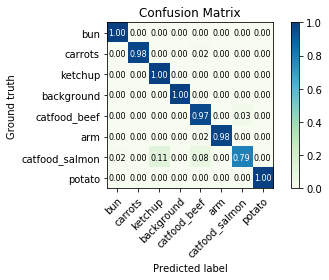

In [15]:
title='Confusion Matrix'
cmap=plt.cm.GnBu
fig, ax = plt.subplots()
im = ax.imshow(confMatrix, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(confMatrix.shape[1]),
       yticks=np.arange(confMatrix.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='Ground truth',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = confMatrix.max() / 2.
for i in range(confMatrix.shape[0]):
    for j in range(confMatrix.shape[1]):
        ax.text(j, i, format(confMatrix[i, j], fmt),
                ha="center", va="center",
                color="white" if confMatrix[i, j] > thresh else "black", fontsize=8)
fig.tight_layout()

In [ ]:
fig.savefig('CNN_confusionMatrix.png', bbox_inches='tight')